In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Load images from folder, preprocess, and convert to grayscale
folder_path = "../Images"
images = []
for filename in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path, filename))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_resized = cv2.resize(img_gray, (256, 256))
    images.append(img_gray_resized/255.0)

# Convert images to PyTorch tensor
images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1) 



C:\Users\nmadali\AppData\Local\Temp\ipykernel_3308\3698301023.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)


In [3]:
images_tensor.shape

torch.Size([4, 1, 256, 256])

In [4]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256*256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 256*256),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0),1, 256, 256)
        return x

In [5]:
# Initialize model
model = Autoencoder()

In [6]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
images_tensor.shape

torch.Size([4, 1, 256, 256])

In [8]:
# Training
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()
    outputs = model(images_tensor)
    loss = criterion(outputs, images_tensor)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    train_losses.append(running_loss)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))



Epoch [1/100], Loss: 0.0862
Epoch [2/100], Loss: 0.2502
Epoch [3/100], Loss: 0.1335
Epoch [4/100], Loss: 0.1039
Epoch [5/100], Loss: 0.0873
Epoch [6/100], Loss: 0.0729
Epoch [7/100], Loss: 0.0599
Epoch [8/100], Loss: 0.0543
Epoch [9/100], Loss: 0.0495
Epoch [10/100], Loss: 0.0462
Epoch [11/100], Loss: 0.0410
Epoch [12/100], Loss: 0.0365
Epoch [13/100], Loss: 0.0327
Epoch [14/100], Loss: 0.0299
Epoch [15/100], Loss: 0.0288
Epoch [16/100], Loss: 0.0269
Epoch [17/100], Loss: 0.0255
Epoch [18/100], Loss: 0.0232
Epoch [19/100], Loss: 0.0223
Epoch [20/100], Loss: 0.0208
Epoch [21/100], Loss: 0.0208
Epoch [22/100], Loss: 0.0201
Epoch [23/100], Loss: 0.0201
Epoch [24/100], Loss: 0.0191
Epoch [25/100], Loss: 0.0187
Epoch [26/100], Loss: 0.0178
Epoch [27/100], Loss: 0.0175
Epoch [28/100], Loss: 0.0176
Epoch [29/100], Loss: 0.0170
Epoch [30/100], Loss: 0.0165
Epoch [31/100], Loss: 0.0162
Epoch [32/100], Loss: 0.0155
Epoch [33/100], Loss: 0.0149
Epoch [34/100], Loss: 0.0149
Epoch [35/100], Loss: 0

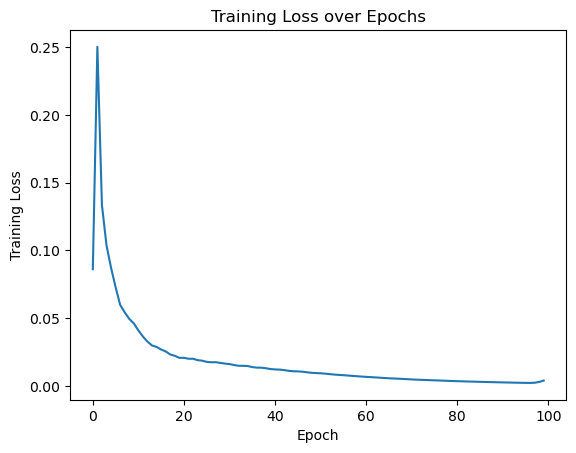

In [9]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

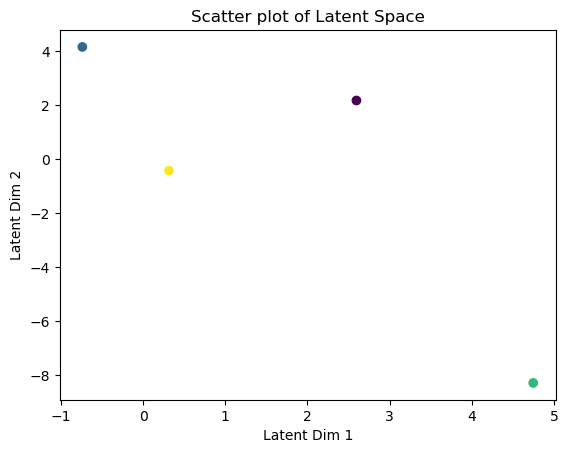

In [10]:
# Scatter plot of latent space
with torch.no_grad():
    latent_points = model.encoder(images_tensor.view(images_tensor.size(0), -1)).numpy()
plt.scatter(latent_points[:, 0], latent_points[:, 1],c=np.arange(len(images)))
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Scatter plot of Latent Space')
plt.show()

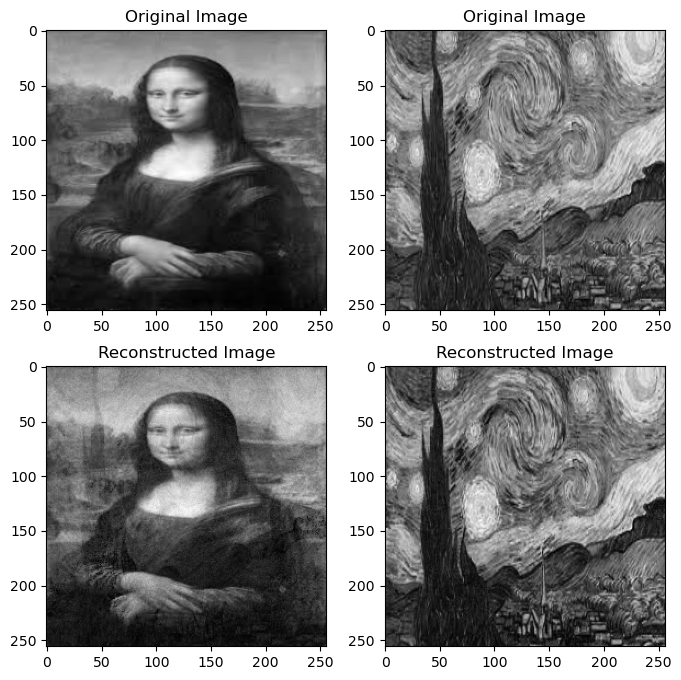

In [11]:
# Reconstruction of selected images
selected_images = images_tensor[:2]
with torch.no_grad():
    reconstructed_images = model(selected_images.view(selected_images.size(0), -1)).numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    axes[0, i].imshow(selected_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title('Original Image')
    axes[1, i].imshow(reconstructed_images[i].reshape(256, 256), cmap='gray')
    axes[1, i].set_title('Reconstructed Image')
plt.show()

In [12]:
# Interpolation between two selected latent points
latent1 = model.encoder(selected_images[0].view(1, -1)).detach().numpy()
latent2 = model.encoder(selected_images[1].view(1, -1)).detach().numpy()
interpolation_points = np.zeros((10, 2))
for i in range(10):
    interpolation_points[i] = latent1 + (latent2 - latent1) * i / 9


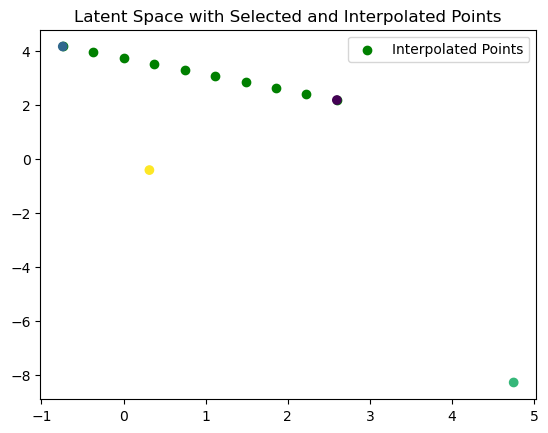

In [13]:
# Draw interpolated points

plt.scatter(interpolation_points[:, 0], interpolation_points[:, 1], color='green', label='Interpolated Points')
plt.scatter(latent_points[:, 0], latent_points[:, 1],c=np.arange(len(images)))
plt.legend()
plt.title('Latent Space with Selected and Interpolated Points')
plt.show()

In [14]:
with torch.no_grad():
    interpolated_images = model.decoder(torch.tensor(interpolation_points).float()).numpy()

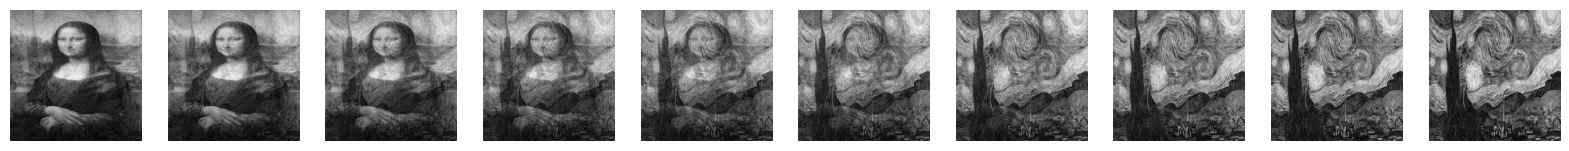

In [15]:


# Plot interpolated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(interpolated_images[i].reshape(256, 256), cmap='gray')
    axes[i].axis('off')
plt.show()